<a href="https://colab.research.google.com/github/ianhstudent/ColabMLNotebook/blob/JPRSubmission/NoResamp_XGBoost_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.datasets import make_classification
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.4 MB/s eta 0:00:00


In [ ]:
# Upload the data file with observations

from google.colab import files
fn = files.upload()


Saving Term&Preterm_AllSamples_20240404.csv to Term&Preterm_AllSamples_20240404.csv


In [ ]:
import io

# Adjust to read the uploaded file (name should already be provided after the upload)
data = pd.read_csv(io.BytesIO(fn['Term&Preterm_AllSamples_20240404.csv']))

print(data)

     Group       Thymine  4-Aminohippuric acid  5-Aminopentanamide  \
0        0  16148.476140           8415.820791         6905.938406   
1        0  24901.941100           8256.863739        14832.413540   
2        0   7641.399579           3974.474322         8179.276112   
3        0  14861.731150           3597.318170         7409.747105   
4        0  24297.212620           1230.643149          999.343056   
..     ...           ...                   ...                 ...   
145      1  12481.279420           6060.336998        11573.555520   
146      1  10958.468430           4564.755171         2608.258373   
147      1   9084.021333           1522.630155         1265.233521   
148      1  29612.010220           3227.926086         1788.734921   
149      1  12011.645970           1581.129616         1996.768786   

     5-Hydroxyoctanoylcarnitine (C10:0-OH)  Acetylcarnitine  Acetylcholine  \
0                             542037.60150     18407.927030    66215.74512   
1  

In [ ]:
# Check the number of features in the data file

n_features = data.shape[1]
print(n_features)

182


In [ ]:
X = data.drop(columns=['Group'])  # All columns except 'Group'
y = data['Group']  # Replace with your target column

print(X)

          Thymine  4-Aminohippuric acid  5-Aminopentanamide  \
0    16148.476140           8415.820791         6905.938406   
1    24901.941100           8256.863739        14832.413540   
2     7641.399579           3974.474322         8179.276112   
3    14861.731150           3597.318170         7409.747105   
4    24297.212620           1230.643149          999.343056   
..            ...                   ...                 ...   
145  12481.279420           6060.336998        11573.555520   
146  10958.468430           4564.755171         2608.258373   
147   9084.021333           1522.630155         1265.233521   
148  29612.010220           3227.926086         1788.734921   
149  12011.645970           1581.129616         1996.768786   

     5-Hydroxyoctanoylcarnitine (C10:0-OH)  Acetylcarnitine  Acetylcholine  \
0                             542037.60150     18407.927030    66215.74512   
1                             705404.28280     27834.145230    58401.76965   
2        

In [ ]:
# Exclude features with over 50% missing values
missing_threshold = 0.5  # 50% threshold
X = X.loc[:, data.isna().mean() <= missing_threshold]

n_features = X.shape[1]
print(n_features)

175


In [ ]:
# Handle missing values in the remaining features using KNN imputation

imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors as needed
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)


In [ ]:
# Perform z-score normalization via a stand scaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

print(X_scaled)

[[ 0.28301548 -0.25640328 -0.25227175 ...  0.09403202  0.20351549
  -0.90407469]
 [ 1.6269845  -0.27395635  1.40909904 ... -0.09750252  1.31165686
  -0.54872333]
 [-1.02312414 -0.74684555  0.01461688 ... -0.8844403  -0.14631883
  -1.15568279]
 ...
 [-0.80163026 -1.01759407 -1.4345504  ... -1.02065451 -0.77471925
  -1.3305173 ]
 [ 2.35014808 -0.82928424 -1.32482572 ... -0.90865676 -0.57308639
  -1.04672183]
 [-0.35213547 -1.01113418 -1.28122231 ... -0.91131114 -0.80402271
  -0.98240467]]


Here we are done with chekcking data for missing values and remove the ones with too many missing values. We also performed log transformation of the data. Next we check on the target file to decide the approach to analyze each target variable.

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
# Train a regression model using the current features
model = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    min_child_weight=5,
    gamma=0,
    colsample_bytree=0.8,
    objective='binary:logistic',  # for binary classification
    nthread=4,
    scale_pos_weight=1,
    seed=42
)
model.fit(X_train, y_train)


# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

Accuracy: 0.70


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


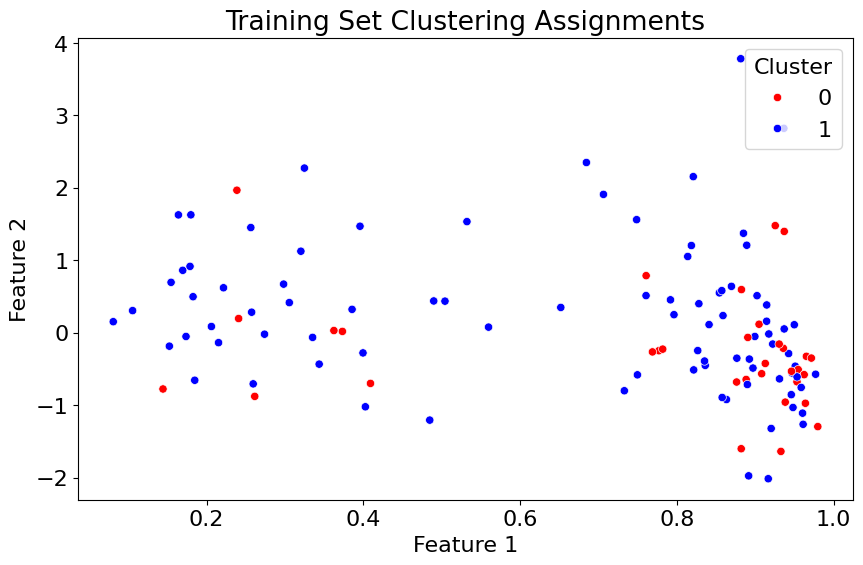

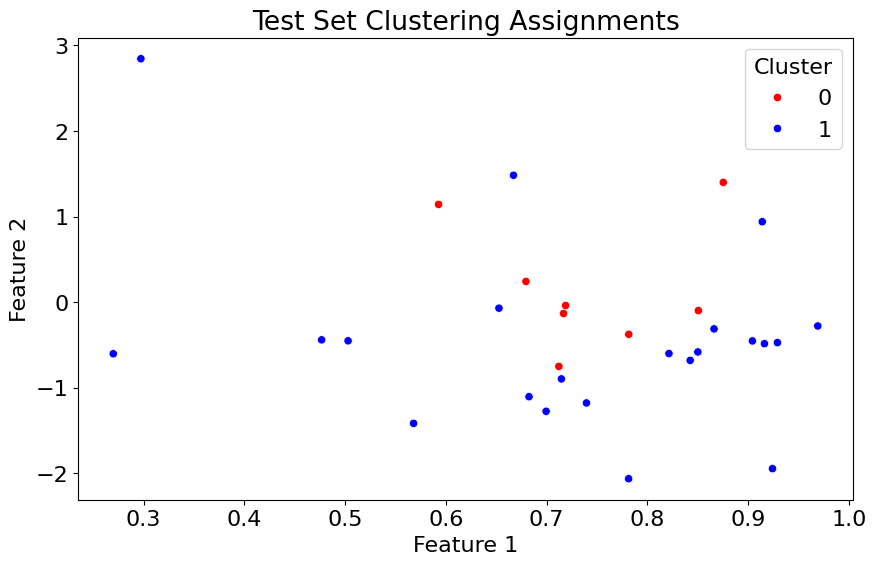

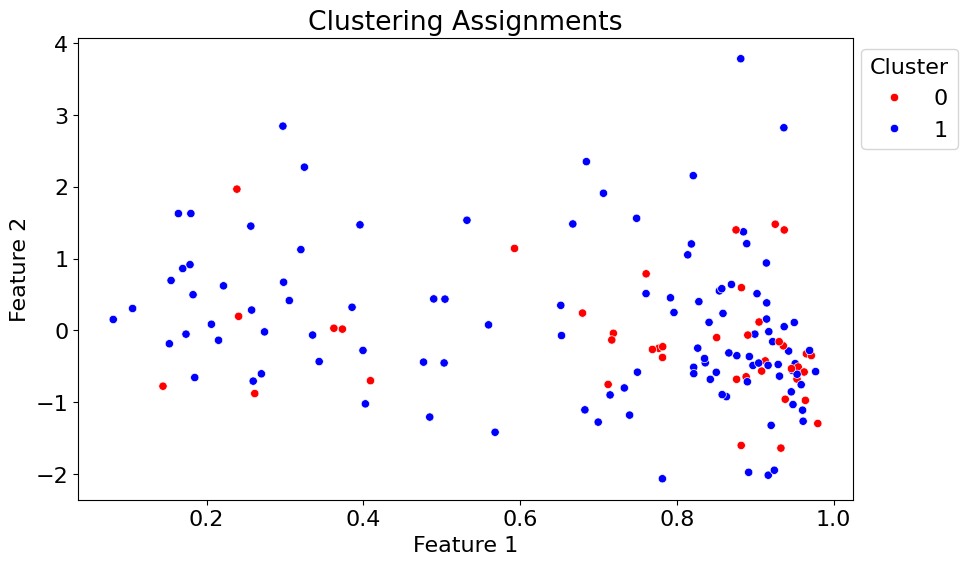

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns


# Assuming model.predict_proba(X_train) and model.predict_proba(X_test) return the predicted probabilities for each class for X_train and X_test respectively
y_train_proba = model.predict_proba(X_train)[:, 1]  # Assuming you're interested in the probabilities of the positive class
y_test_proba = model.predict_proba(X_test)[:, 1]

# Define the number of clusters (you may adjust this based on your dataset)
n_clusters = 2

# Create a feature matrix using the predicted probabilities
X_train_cluster = np.column_stack((y_train_proba, X_train))  # Add predicted probabilities as the first feature
X_test_cluster = np.column_stack((y_test_proba, X_test))

# Perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
train_cluster_labels = kmeans.fit_predict(X_train_cluster)
test_cluster_labels = kmeans.predict(X_test_cluster)

cluster_colors = ['red', 'blue']

# Visualize clustering assignments
plt.figure(figsize=(10, 6))

plt.rcParams.update({'font.size': 16})  # Adjust font size as needed for all figures

sns.scatterplot(x=X_train_cluster[:, 0], y=X_train_cluster[:, 1], hue=train_cluster_labels, palette=cluster_colors, legend='full')
plt.title('Training Set Clustering Assignments')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster', loc='upper right')
plt.grid(False)
plt.show()
3
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_cluster[:, 0], y=X_test_cluster[:, 1], hue=test_cluster_labels, palette=cluster_colors, legend='full')
plt.title('Test Set Clustering Assignments')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster', loc='upper right')
plt.grid(False)
plt.show()

# Combine the features and cluster labels for both training and test sets
X_combined = np.concatenate((X_train_cluster[:, :2], X_test_cluster[:, :2]))  # Concatenate first two columns
cluster_labels_combined = np.concatenate((train_cluster_labels, test_cluster_labels))

# Visualize clustering assignments for combined data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_combined[:, 0], y=X_combined[:, 1], hue=cluster_labels_combined, palette=cluster_colors, legend='full')
plt.title('Clustering Assignments')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(title='Cluster', loc='upper right',bbox_to_anchor=(1.15, 1))
plt.grid(False)
plt.show()

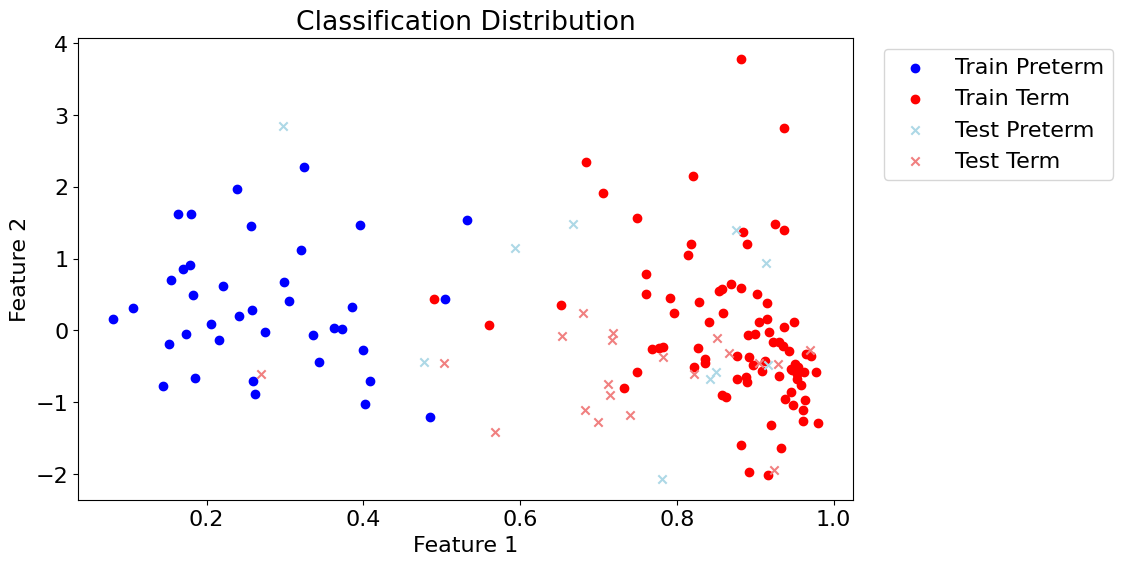

In [ ]:
import matplotlib.pyplot as plt


# Extract coordinates of data points for each class
train_class_0_points = X_train_cluster[y_train == 0]
train_class_1_points = X_train_cluster[y_train == 1]
test_class_0_points = X_test_cluster[y_test == 0]
test_class_1_points = X_test_cluster[y_test == 1]

# Plot data points

plt.figure(figsize=(10, 6))

plt.rcParams.update({'font.size': 16})  # Adjust font size as needed for all figures

plt.scatter(train_class_0_points[:, 0], train_class_0_points[:, 1], color='blue', label='Train Preterm')
plt.scatter(train_class_1_points[:, 0], train_class_1_points[:, 1], color='red', label='Train Term')
plt.scatter(test_class_0_points[:, 0], test_class_0_points[:, 1], color='lightblue', marker='x', label='Test Preterm')
plt.scatter(test_class_1_points[:, 0], test_class_1_points[:, 1], color='lightcoral', marker='x', label='Test Term')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Classification Distribution')
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1))
plt.show()

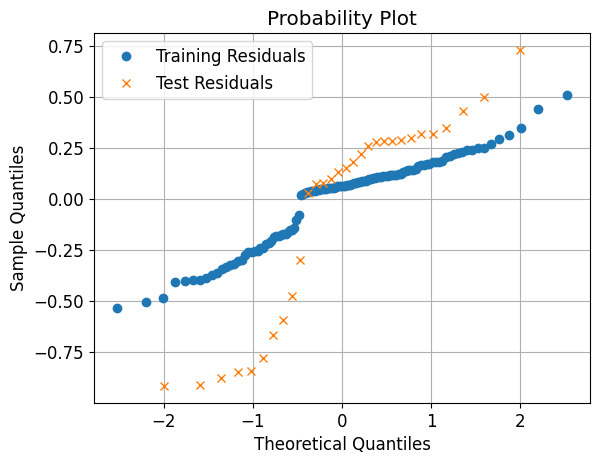

In [ ]:
#Mapping Probability

import scipy.stats as stats
import matplotlib.pyplot as plt

y_train_proba = model.predict_proba(X_train)[:, 1]  # Assuming you're interested in the probabilities of the positive class
y_test_proba = model.predict_proba(X_test)[:, 1]

# Compute residuals
train_residuals = y_train - y_train_proba
test_residuals = y_test - y_test_proba

# Generate normal probability plot for training residuals
res_train = stats.probplot(train_residuals, dist="norm", plot=None)

# Generate normal probability plot for test residuals
res_test = stats.probplot(test_residuals, dist="norm", plot=None)

# Plotting
plt.plot(res_train[0][0], res_train[0][1], marker='o', linestyle='', label='Training Residuals')
plt.plot(res_test[0][0], res_test[0][1], marker='x', linestyle='', label='Test Residuals')

plt.title('Probability Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.legend()
plt.grid(True)
plt.show()

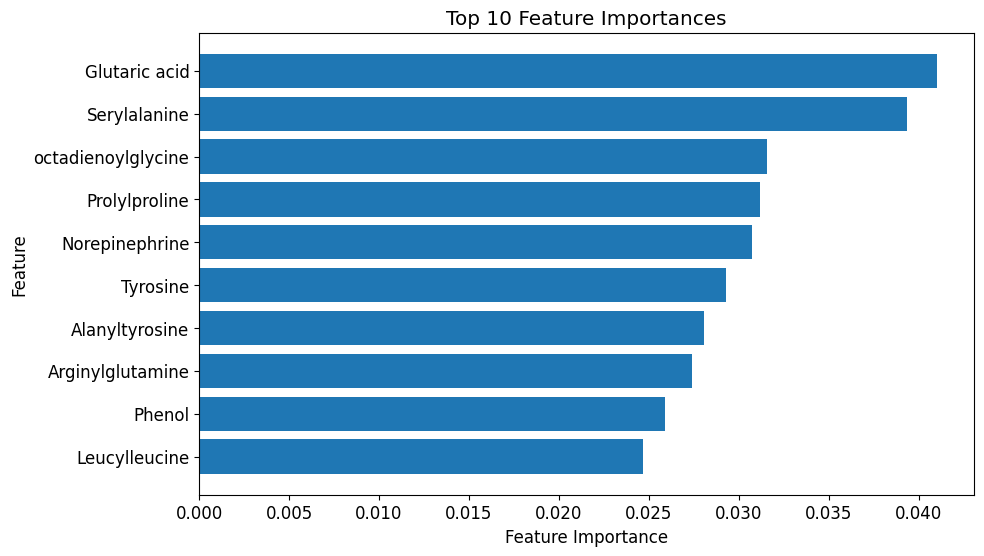

In [ ]:
# Assess Feature Importance


# Get feature importances from the trained model
feature_importances = model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Get the top N feature names and importances (adjust N as needed)
top_n = 10
top_feature_indices = sorted_indices[:top_n]
top_feature_names = feature_names[top_feature_indices]
top_feature_importances = feature_importances[top_feature_indices]

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))

plt.rcParams.update({'font.size': 12})  # Adjust font size as needed

plt.barh(range(top_n), top_feature_importances, align="center")
plt.yticks(range(top_n), top_feature_names)  # Use yticks instead of xticks
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Feature Importances")
plt.gca().invert_yaxis()  # Invert the y-axis for better readability
plt.show()

Accuracy: 0.70
AUC-ROC: 0.50


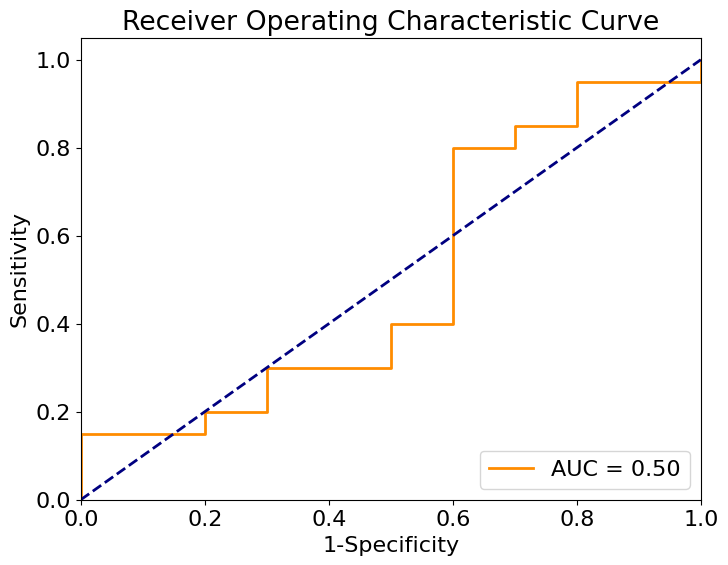

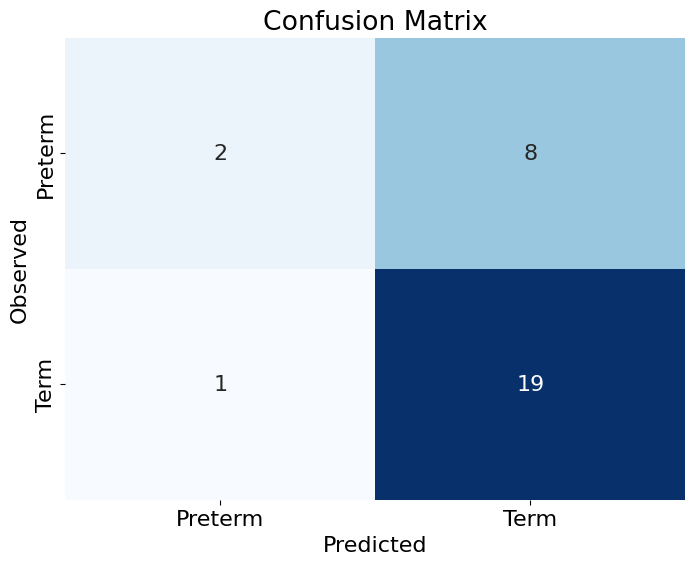

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Calculate AUC-ROC
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of class 1
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC: {auc_score:.2f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))

plt.rcParams.update({'font.size': 16})  # Adjust font size as needed

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Preterm", "Term"], yticklabels=["Preterm", "Term"])
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.title('Confusion Matrix')

plt.show()

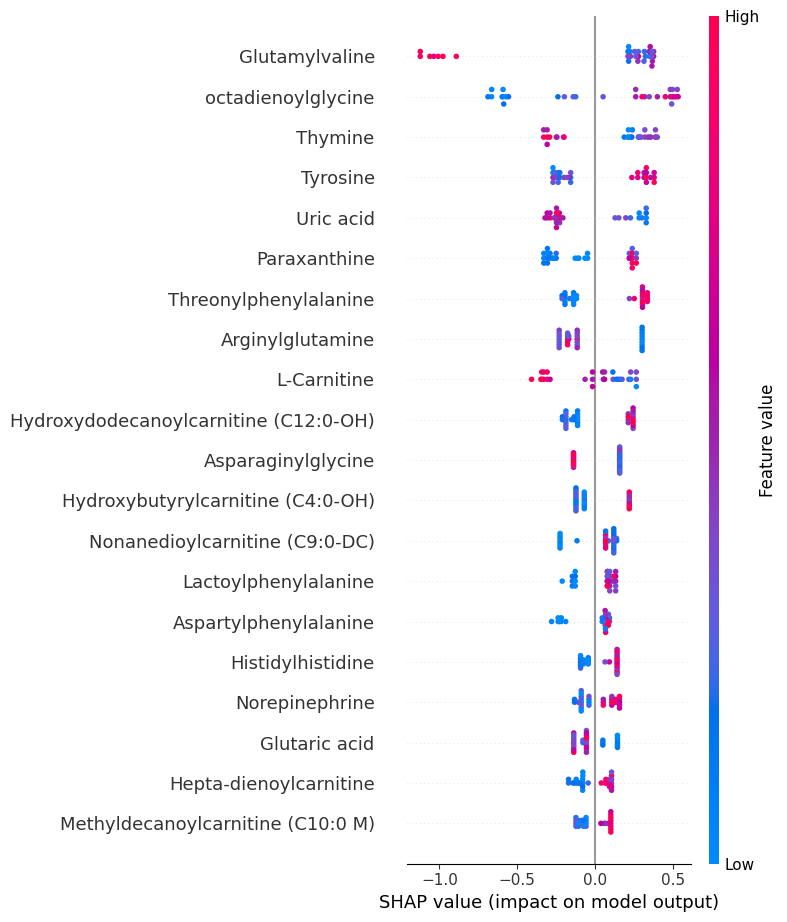

In [ ]:
#Shap evlauation of feature improtance

# Use SHAP to explain feature importances
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summarize the feature importance values
shap.summary_plot(shap_values, X_test, feature_names=X.columns)